## Purpose

**Abstract**: Find all the dips in Gaia FG dwarfs in ZTF DR14 photometry.

In [74]:
# magic for real time editing of .py files
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
from scipy.optimize import curve_fit
import astropy.stats as astro_stats
from astropy.io import ascii
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
import lsdb
from tqdm import tqdm
import dask
dask.config.set({"temporary-directory" :'/epyc/ssd/users/atzanida/tmp'})

In [3]:
%%time 

#Load ZTF, Gaia, and ZTF sources hipscats # note data3/ for epyc
gaia = lsdb.read_hipscat("/epyc/data3/hipscat/test_catalogs/gaia_symbolic", 
                        columns=['ra', 'dec', 'parallax', 'parallax_over_error', 
                                'bp_rp', 'solution_id', 
                                'source_id', 
                                'pmra', 'pmra_error', 
                                'pmdec', 'pmdec_error', 
                                'parallax_error', 
                                'phot_g_mean_mag', 
                                'l', 'b', 'non_single_star', 
                                'classprob_dsc_combmod_galaxy', 
                                'classprob_dsc_combmod_star', 
                                 'in_qso_candidates',
                                'teff_gspphot', 'teff_gspphot_upper', 'teff_gspphot_lower',
                                'logg_gspphot', 'logg_gspphot_lower', 'logg_gspphot_upper',
                                'mh_gspphot','mh_gspphot_lower', 'mh_gspphot_upper',
                                'distance_gspphot', 'distance_gspphot_lower','distance_gspphot_upper',
                                'azero_gspphot', 'azero_gspphot_lower', 'azero_gspphot_upper', 'ag_gspphot', 
                                 'ebpminrp_gspphot', 'ebpminrp_gspphot_lower', 'ebpminrp_gspphot_upper',
                                'Norder', 'Npix', 'Dir'])

# load ZTF object table
ztf = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")

# Load ZTF DR14 sources
ztf_sources = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_source")

CPU times: user 52.4 s, sys: 8.97 s, total: 1min 1s
Wall time: 1min 3s


In [4]:
%%time
# crossmatch ZTF + Gaia
_all_sky_object = gaia.crossmatch(ztf).query(
    "nobs_g_ztf_dr14 > 50 and nobs_r_ztf_dr14 > 50 and \
    parallax_gaia > 0 and parallax_over_error_gaia > 5 and \
    teff_gspphot_gaia > 5380 and teff_gspphot_gaia < 7220 and logg_gspphot_gaia > 4.5 \
    and logg_gspphot_gaia < 4.72 and classprob_dsc_combmod_star_gaia > 0.5")

CPU times: user 6.68 s, sys: 1.21 s, total: 7.89 s
Wall time: 7.84 s


In [5]:
%%time
# compute gaia-ztf_object crossmatch table
_all_sky_object = _all_sky_object.compute()

CPU times: user 1h 34min 9s, sys: 1h 36min 30s, total: 3h 10min 39s
Wall time: 20min 44s


In [6]:
print (f"Number of unique sources: {len(_all_sky_object.index.unique())}")

Number of unique sources: 4833834


In [7]:
%%time 
# Convert crossmatch _sample to lsdb Catalog object
_sample_hips = lsdb.from_dataframe(
    _all_sky_object, 
    lowest_order=5, 
    highest_order=8, 
    ra_column="ra_gaia", 
    dec_column="dec_gaia", 
    threshold=1_000_000
)

CPU times: user 2min 54s, sys: 8.76 s, total: 3min 3s
Wall time: 3min 1s


In [133]:
# Stored on Feb 2nd 2024, @
%%time
_sample_hips.to_hipscat("nvme/users/atzanida/tmp/data_files/", "andy_fg_dwarfs")

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 2.01 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 22min 35s, sys: 1h 1min 19s, total: 1h 23min 54s
Wall time: 44min 54s


In [8]:
%%time
_sources = _sample_hips.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid")

CPU times: user 1min 35s, sys: 5.52 s, total: 1min 40s
Wall time: 1min 40s


## TAPE

In [76]:
import dask.dataframe as dd
from tape import Ensemble, ColumnMapper

## Time Series Functions

In [10]:
def peak_detector(times, dips, power_thresh=3, pk_2_pk_cut=30):
    """
    Run and compute dip detection algorithm on a light curve.
    
    Parameters:
    -----------
    times (array-like): Time values of the light curve.
    dips (array-like): Deviation values of the light curve.
    power_thresh (float): Threshold for the peak detection. Default is 3.
    pk_2_pk_cut (float): Minimum peak to peak separation. Default is 30 days.

    Returns:
    --------
    N_peaks (int): Number of peaks detected.
    dip_summary (dict): Summary of the dip. Including the peak location, the window start and end, the number of 1 sigma detections in the dip, the number of detections in the dip, the forward and backward duration of the dip, and the dip power.
    """

    if len(dips)==0:
        return None, None

    # Scipy peak finding algorithm
    pks, _ = find_peaks(dips, height=power_thresh, distance=pk_2_pk_cut) #TODO: is 100 days peak separation too aggresive?

    # Reverse sort the peak values
    pks = np.sort(pks)[::-1]
    
    # Time of peaks and dev of peaks
    t_pks, p_pks = times[pks], dips[pks]
    
    # Number of peaks
    N_peaks = len(t_pks)
    
    dip_summary = {}
    for i, (time_ppk, ppk) in enumerate(zip(t_pks, p_pks)):        
        dip_summary[f'dip_{i}'] = {
            "peak_loc": time_ppk,
            "dip_power":ppk,
        }
                
    return N_peaks, dip_summary

In [11]:
def prepare_lc(time, mag, mag_err, flag, band, band_of_study='r', flag_good=0):
    """
    Prepare the light curve for analysis - specifically for the ZTF data.
    
    Parameters:
    -----------
    time (array-like): Input time values.
    mag (array-like): Input magnitude values.
    mag_err (array-like): Input magnitude error values.
    flag (array-like): Input flag values.
    band (array-like): Input band values.
    band_of_study (str): Band to study. Default is 'r' band
    flag_good (int): Flag value for good detections. Default is 0 (see ZTF documentation)

    Returns:
    --------
    time (array-like): Output time values.
    mag (array-like): Output magnitude values.
    mag_err (array-like): Output magnitude error values.
    """
    # Selection and preparation of the light curve (default selection on )
    rmv = (flag == flag_good) & (mag_err>0) & (band==band_of_study) & (~np.isnan(time)) & (~np.isnan(mag)) & (~np.isnan(mag_err)) # remove nans!
    
    time, mag, mag_err = time[rmv], mag[rmv], mag_err[rmv]
    
    # sort time
    srt = time.argsort()

    # Remove repeated entries
    time, mag, mag_err = time[srt], mag[srt], mag_err[srt]
    ts = abs(time - np.roll(time, 1)) > 1e-5
    
    if len(time[ts])>0:
        return time[ts], mag[ts], mag_err[ts]
    else:
        return None, None, None

In [12]:
def deviation(mag, mag_err, R, S):
    """Calculate the running deviation of a light curve for outburst or dip detection.
    
    d >> 0 will be dimming
    d << 0 (or negative) will be brightenning
    
    
    Parameters:
    -----------
    mag (array-like): Magnitude values of the light curve.
    mag_err (array-like): Magnitude errors of the light curve.
    R (float): Biweight location of the light curve (global).
    S (float): Biweight scale of the light curve (global).

    Returns:
    --------
    dev (array-like): Deviation values of the light curve.
    """
    # Calculate biweight estimators
    return (mag - R) / np.sqrt(mag_err**2 + S**2)

## Test Peak Finding

In [15]:
lc = ascii.read("https://ztf.snad.space/dr17/csv/741107200001800")

In [16]:
dev = deviation(lc['mag'], lc['magerr'],
                astro_stats.biweight_location(lc['mag']), 
               astro_stats.biweight_scale(lc['mag']))

In [17]:
npeak, peak_dict = peak_detector(lc['mjd'], dev, power_thresh=2)

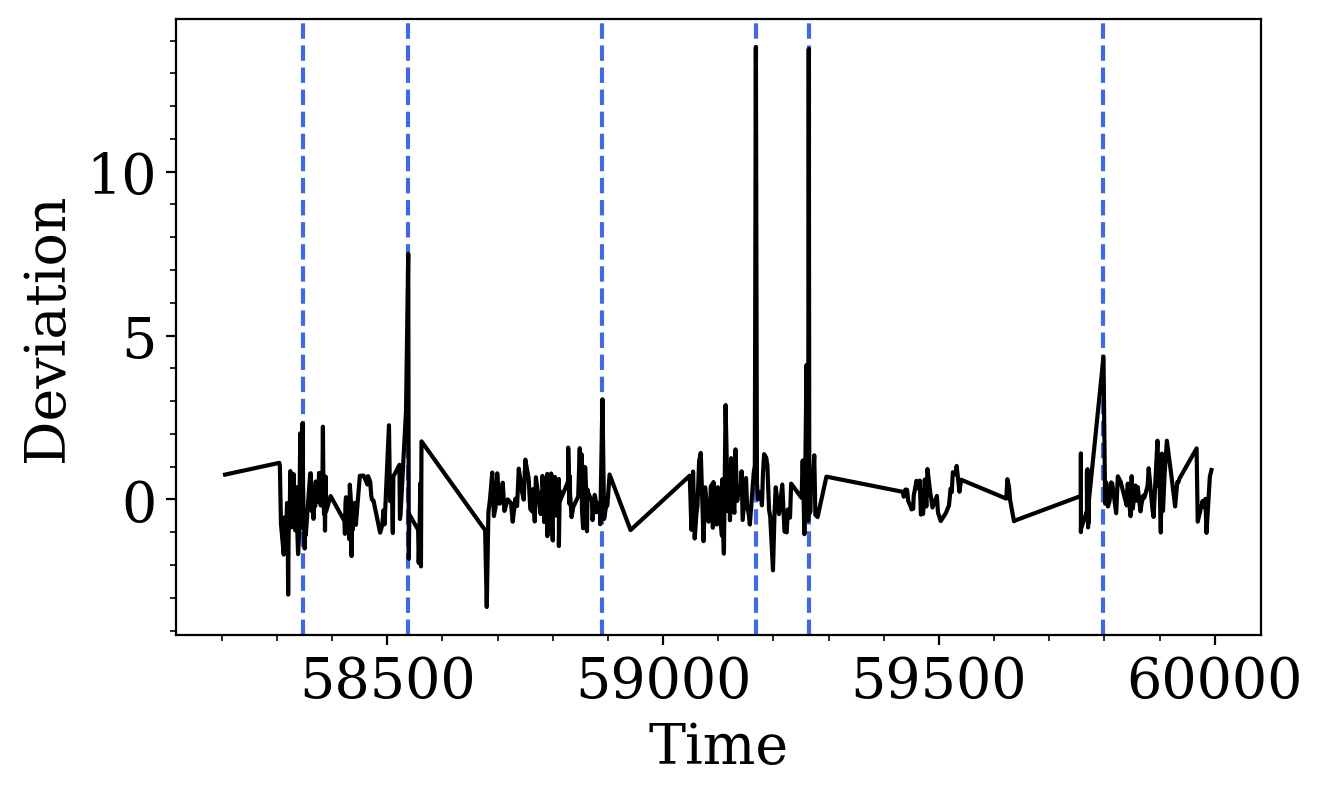

In [18]:
plt.figure(figsize=(7,4))

for i in range(npeak):
    plt.axvline(peak_dict[f'dip_{i}']['peak_loc'], ls='--', color='royalblue')

plt.plot(lc['mjd'], dev, color='k')
plt.ylabel("Deviation")
plt.xlabel("Time")
plt.minorticks_on()

## Initialize TAPE

In [107]:
# Initialize an Ensemble
ens = Ensemble(memory_limit=1e11, n_workers=12)
ens.client_info()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39588 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:39588/status,
Dashboard: http://127.0.0.1:39588/status,Workers: 12
Total threads: 96,Total memory: 1.09 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35227,Workers: 12
Dashboard: http://127.0.0.1:39588/status,Total threads: 96
Started: Just now,Total memory: 1.09 TiB
Comm: tcp://127.0.0.1:46180,Total threads: 8
Dashboard: http://127.0.0.1:38878/status,Memory: 93.13 GiB
Nanny: tcp://127.0.0.1:42497,


In [108]:
# ColumnMapper Establishes which table columns map to timeseries quantities
colmap = ColumnMapper(
        id_col='_hipscat_index',
        time_col='mjd',
        flux_col='mag',
        err_col='magerr',
        band_col='band',
      )

ens.from_dask_dataframe(
    source_frame=_sources._ddf,
    object_frame=_sample_hips._ddf,
    column_mapper=colmap,
    sync_tables=False, # Avoid doing an initial sync
    sorted=True, # If the input data is already sorted by the chosen index
    sort=False,
)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(


# Implementation New

In [109]:
def blc(time, mag, mag_err, flag, band):
    
    try:
        time, mag, mag_err = prepare_lc(time, mag, mag_err, flag, band,  band_of_study='r', flag_good=0)

        if time is not None:
            # Calculate deviation
            dev = deviation(mag, mag_err,
                        astro_stats.biweight_location(mag), 
                       astro_stats.biweight_scale(mag))

            # detect peaks
            npeak, peak_dict = peak_detector(time, dev, power_thresh=1)

            source = 1

            if npeak>0:
                # append variables and store...
                X, Y, Z = [], [], []
                for i in range(npeak):
                    X.append(peak_dict[f'dip_{i}']['peak_loc'])
                    Y.append(peak_dict[f'dip_{i}']['dip_power'])
                    Z.append(source) # this is the PS1 ID!

                # Store dataframe
                #data_store = pd.DataFrame({"ps1_id":Z, "dip_loc":X, "dip_power":Y})
                
                # Open csv template
                #template = dask.dataframe.read_csv("temp/alias_dips.csv")                    
                #dask.dataframe.concat([template, data_store]).compute().to_csv("temp/alias_dips.csv", index=False)
            
                return pd.Series({"peak_loc":X, "peak_power":Y, "source_id":Z})
        else:
            return pd.Series({"peak_loc":np.nan, "peak_power":np.nan, "source_id":np.nan})
        
    except:
        return pd.Series({"peak_loc":np.nan, "peak_power":np.nan, "source_id":np.nan})


In [110]:
# Define output columns
output_cols = ["peak_loc", "peak_power", "source_id"]

# Define DataFrame with loc and scale as meta
my_meta = pd.DataFrame(columns=output_cols, dtype=float)

In [111]:
%%time
# apply calc_features function
calc_ = ens.batch(
    blc,
    'mjd_ztf_source', 'mag_ztf_source', 'magerr_ztf_source',
    'catflags_ztf_source','band_ztf_source',
    meta=my_meta,
    use_map=True)

Using generated label, result_1, for a batch result.
CPU times: user 733 ms, sys: 296 ms, total: 1.03 s
Wall time: 876 ms


In [112]:
%%time
ens.object.join(calc_).update_ensemble()

CPU times: user 7.02 s, sys: 2.9 s, total: 9.91 s
Wall time: 8.24 s


In [120]:
%%time
test_table = ens.object.head(5_000, npartitions=1_000)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 29.30 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 7min 59s, sys: 19min 54s, total: 27min 54s
Wall time: 15min 39s


In [134]:
test_table

,ra_gaia,dec_gaia,parallax_gaia,parallax_over_error_gaia,bp_rp_gaia,solution_id_gaia,source_id_gaia,pmra_gaia,pmra_error_gaia,pmdec_gaia,...,Norder_ztf_dr14,Dir_ztf_dr14,Npix_ztf_dr14,_DIST,Norder,Dir,Npix,peak_loc,peak_power,source_id
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
10595126476800,44.920804,0.146074,0.379842,5.828582,0.895802,1636148068921376768,5291399870976,1.774002,0.071176,-3.285704,...,3,0,0,0.000034,5,0,0,"[59801.47829, 59231.18398, 59184.30787, 59123....","[1.4779677, 2.169328, 1.4524883, 1.735336, 1.3...","[1, 1, 1, 1, 1, 1, 1, 1]"
16507971043328,44.998582,0.230765,0.734424,9.088769,0.913288,1636148068921376768,8250632981888,16.249828,0.101591,-15.073231,...,3,0,0,0.000151,5,0,0,[58773.33313],[5.0722136],[1]
29151004196864,45.022036,0.286649,0.832968,23.938770,0.909290,1636148068921376768,14572824839168,16.714367,0.044151,-12.413687,...,3,0,0,0.000009,5,0,0,"[59537.35824, 59231.184, 59157.43167, 59094.43...","[1.0781367, 1.411664, 1.3133433, 1.4489608, 1....","[1, 1, 1, 1, 1, 1, 1, 1, 1]"
38478934966272,44.781045,0.257446,0.369344,8.980508,0.776276,1636148068921376768,19211389524736,1.754767,0.046903,1.655142,...,3,0,0,0.000023,5,0,0,"[59521.28618, 59224.21666, 59158.35304, 58803....","[1.4054593, 1.1834198, 2.077293, 2.0625358, 2....","[1, 1, 1, 1, 1, 1]"
85431517446144,45.374304,0.527956,1.282698,33.847800,1.030265,1636148068921376768,42713450599296,22.816147,0.040244,-12.039823,...,3,0,0,0.000019,5,0,0,"[59231.18404, 59186.32076, 59088.44322, 58760....","[2.6854582, 1.502144, 2.2609234, 1.4278809, 1....","[1, 1, 1, 1, 1, 1, 1]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51223635469271040,41.364016,12.511852,1.345369,29.046875,1.057473,1636148068921376768,25611821994690176,24.555673,0.055569,-1.281187,...,3,0,2,0.000020,5,0,45,"[59806.43405, 59298.12619, 59158.3495, 58856.1...","[2.033135, 4.0356345, 1.645727, 2.6473777, 1.0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
51235541370273792,40.150249,11.573226,0.786373,15.088685,1.044270,1636148068921376768,25617766229324416,28.427340,0.056010,-34.123170,...,3,0,2,0.000026,5,0,45,"[59810.47158, 59479.40818, 59298.12367, 59260....","[2.0741851, 1.0901444, 2.712778, 1.5250825, 2....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
51245284545527808,40.110919,11.674578,1.316027,39.666634,1.047323,1636148068921376768,25622645312170624,10.490463,0.041028,3.647949,...,3,0,2,0.000026,5,0,45,"[58801.31749, 58773.32523, 58425.28836]","[2.313689, 2.374945, 1.099825]","[1, 1, 1]"


## Investigate Peaks

In [122]:
xloc = []
ypow = []
for i in tqdm(range(5_000)):
    try:
        for j in range(len(test_table['peak_loc'].iloc[i])):
            xloc.append(test_table['peak_loc'].iloc[i][j])
            ypow.append(test_table['peak_power'].iloc[i][j])
    except:
        continue
        
xloc = np.array(xloc)
ypow = np.array(ypow)

100%|██████████| 5000/5000 [00:01<00:00, 2658.06it/s]


In [123]:
len(xloc), len(ypow)

(36577, 36577)

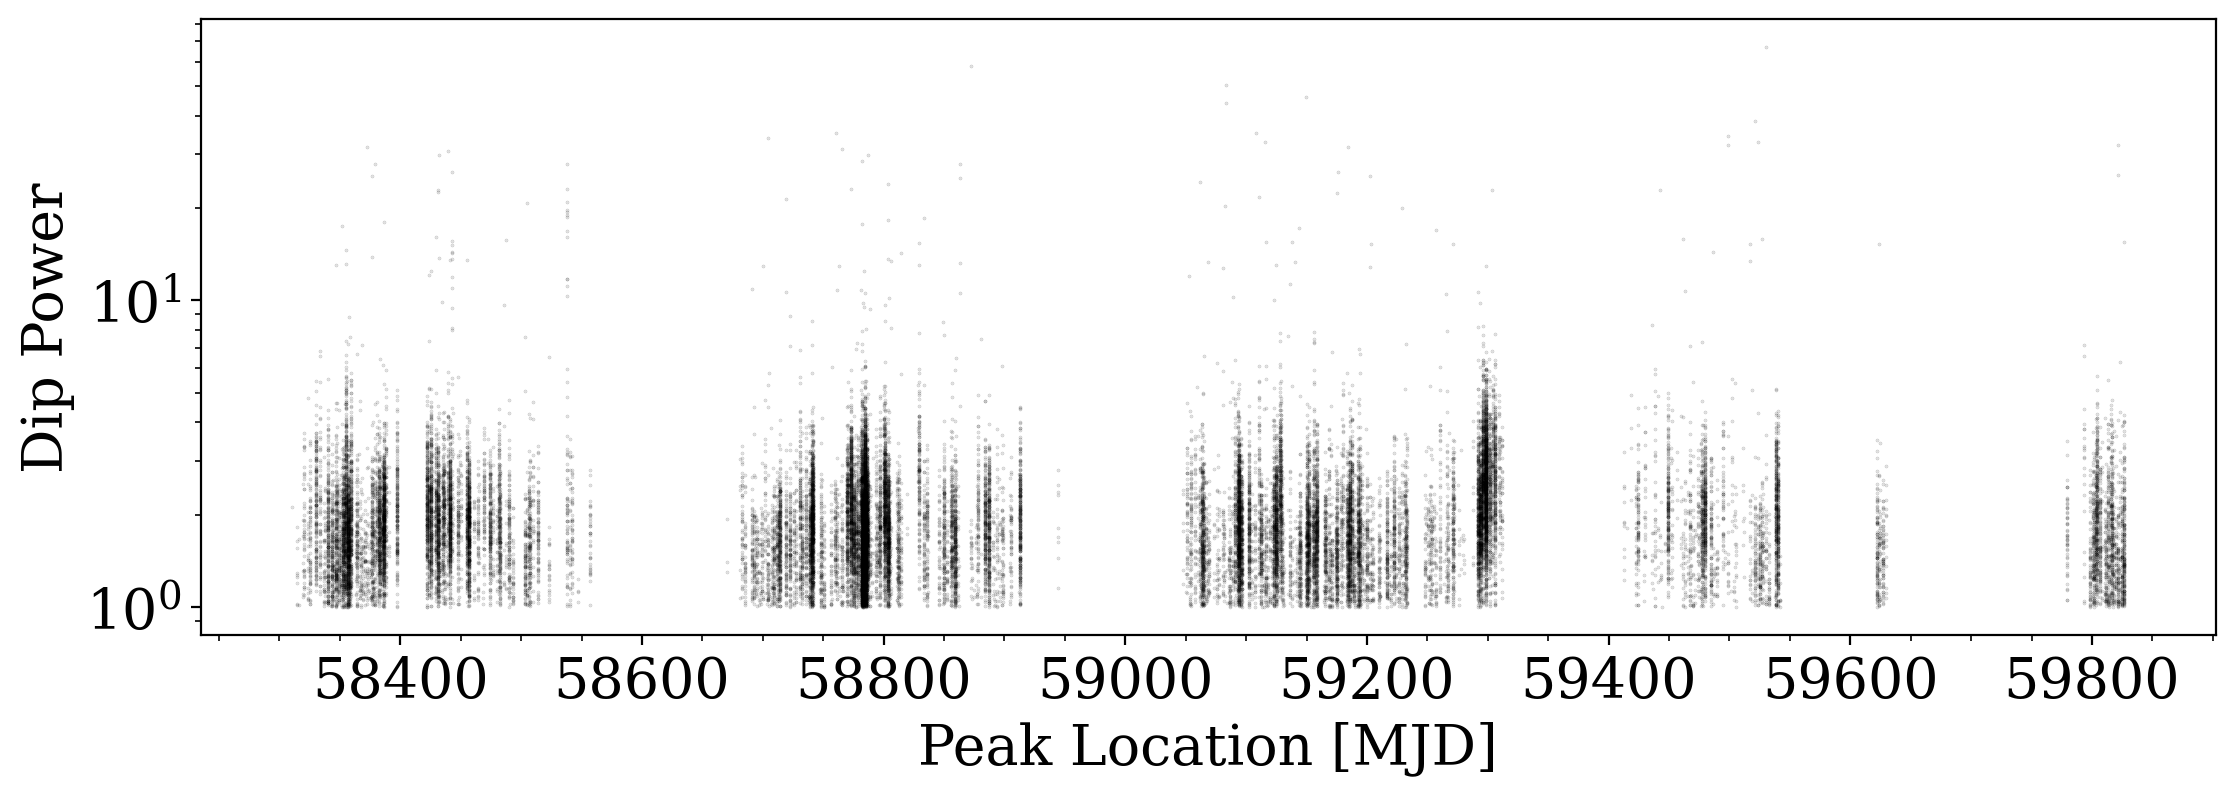

In [124]:
plt.figure(figsize=(13, 4))
plt.scatter(xloc, ypow,
            s=0.1, color='k', alpha=0.2)

plt.minorticks_on()
plt.ylabel("Dip Power")
plt.xlabel("Peak Location [MJD]")
plt.yscale('log')


(-59.7, 0.0)

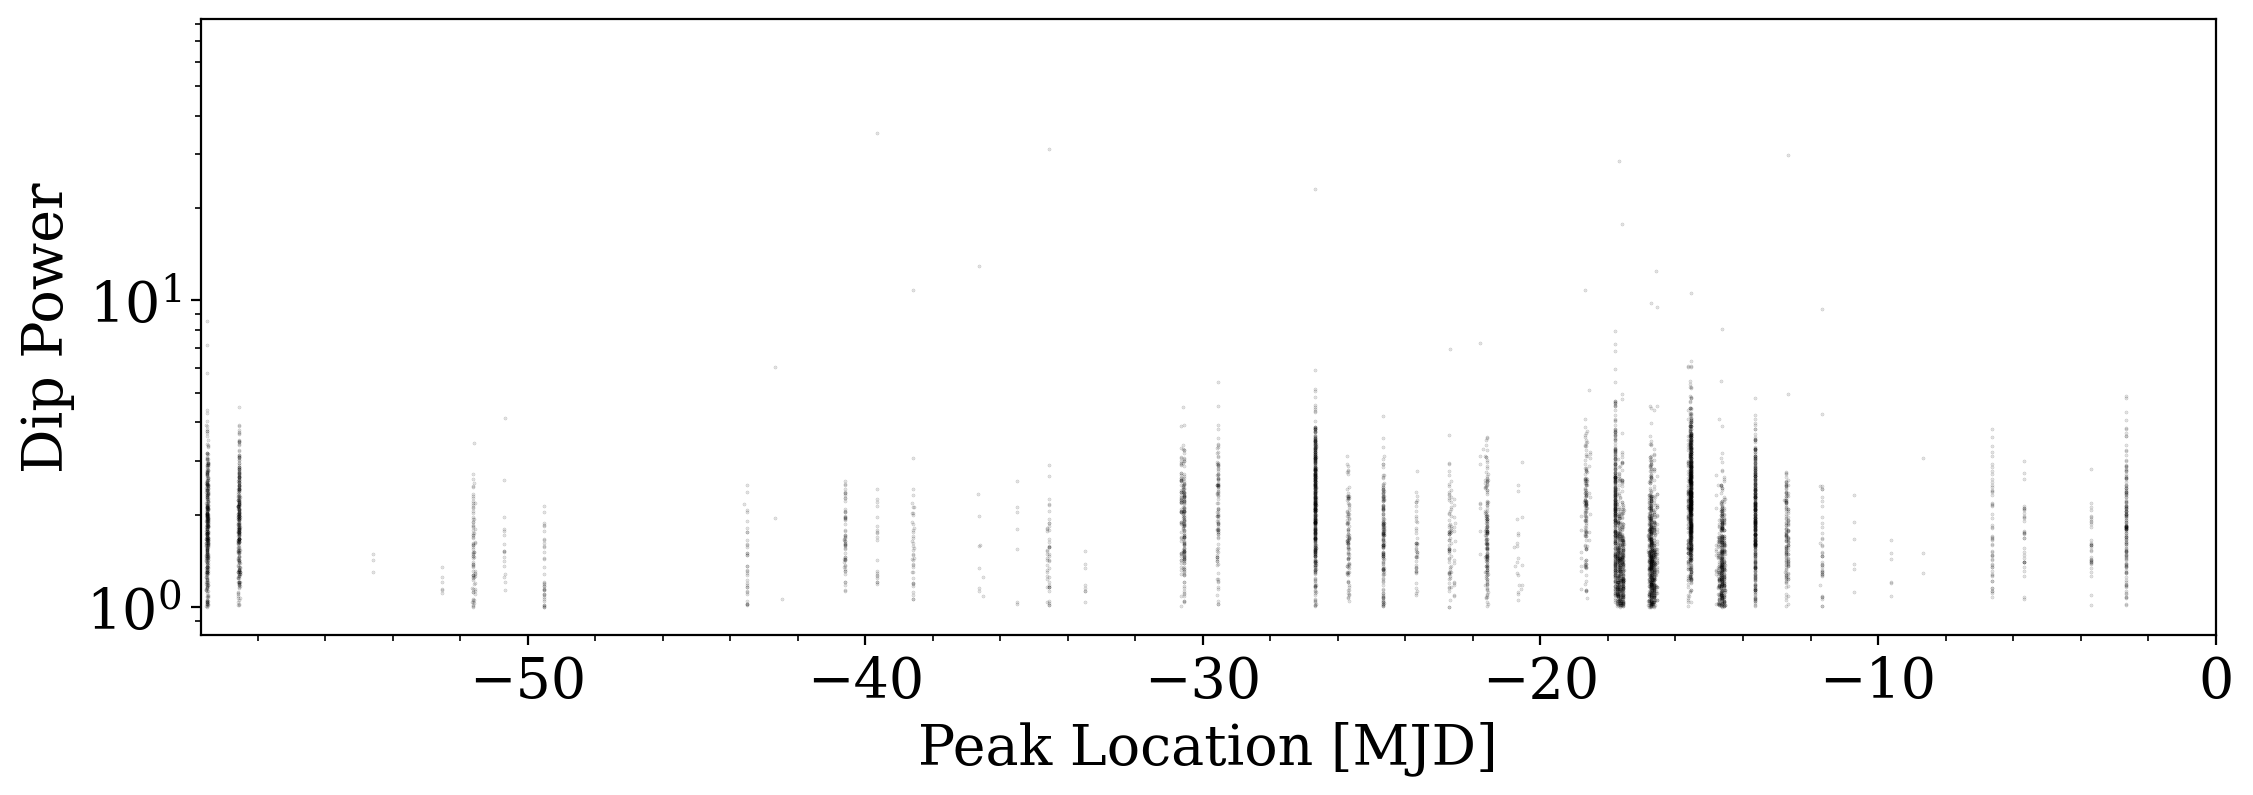

In [125]:
plt.figure(figsize=(13, 4))
plt.scatter(xloc-58800, ypow,
            s=0.1, color='k', alpha=0.2)

plt.minorticks_on()
plt.ylabel("Dip Power")
plt.xlabel("Peak Location [MJD]")
plt.yscale('log')
plt.xlim(-59.7, 0)


In [126]:
from astropy.timeseries import LombScargle

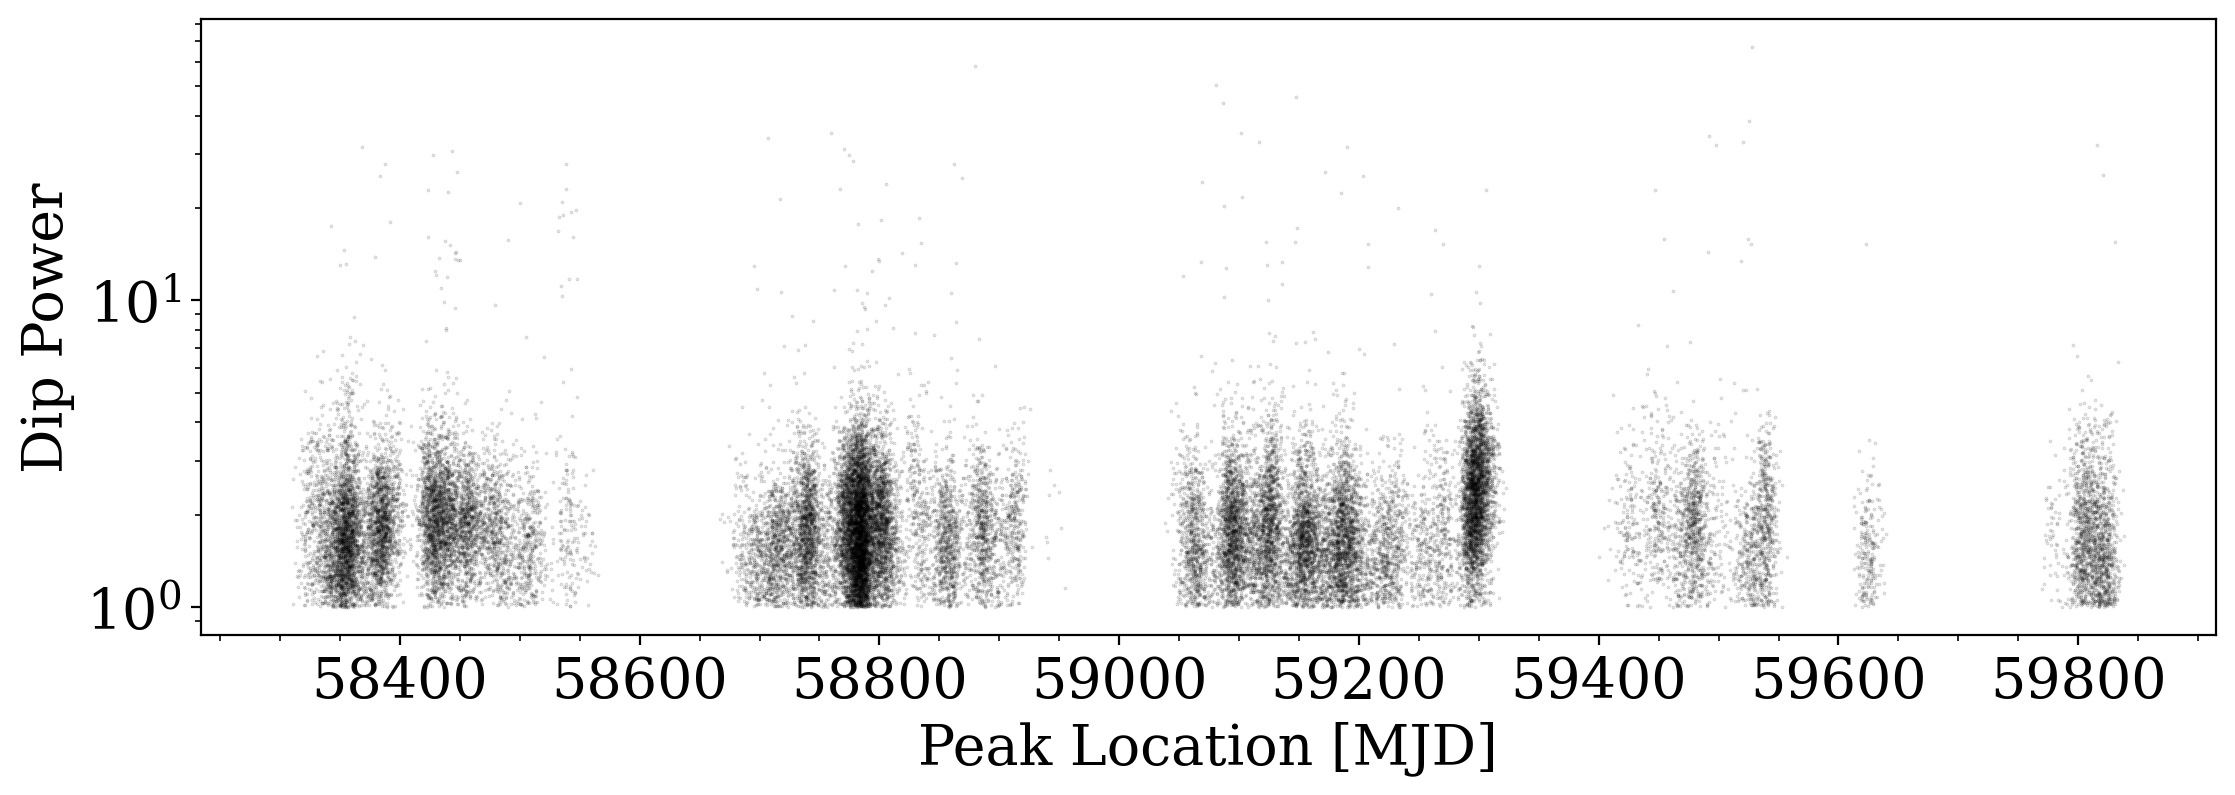

In [127]:
plt.figure(figsize=(13, 4))
plt.scatter(xloc+np.random.normal(0, 5, len(xloc)),
            (ypow),
            s=0.1, color='k', alpha=0.2)

plt.minorticks_on()
plt.ylabel("Dip Power")
plt.xlabel("Peak Location [MJD]")
plt.yscale('log')


In [241]:
frequency, power = LombScargle(xloc, ypow).autopower()

In [242]:
frequency2, power2 = LombScargle(xloc+np.random.normal(0, 10, len(xloc)), 
                                 ypow).autopower()

Text(0, 0.5, 'LSP Power')

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


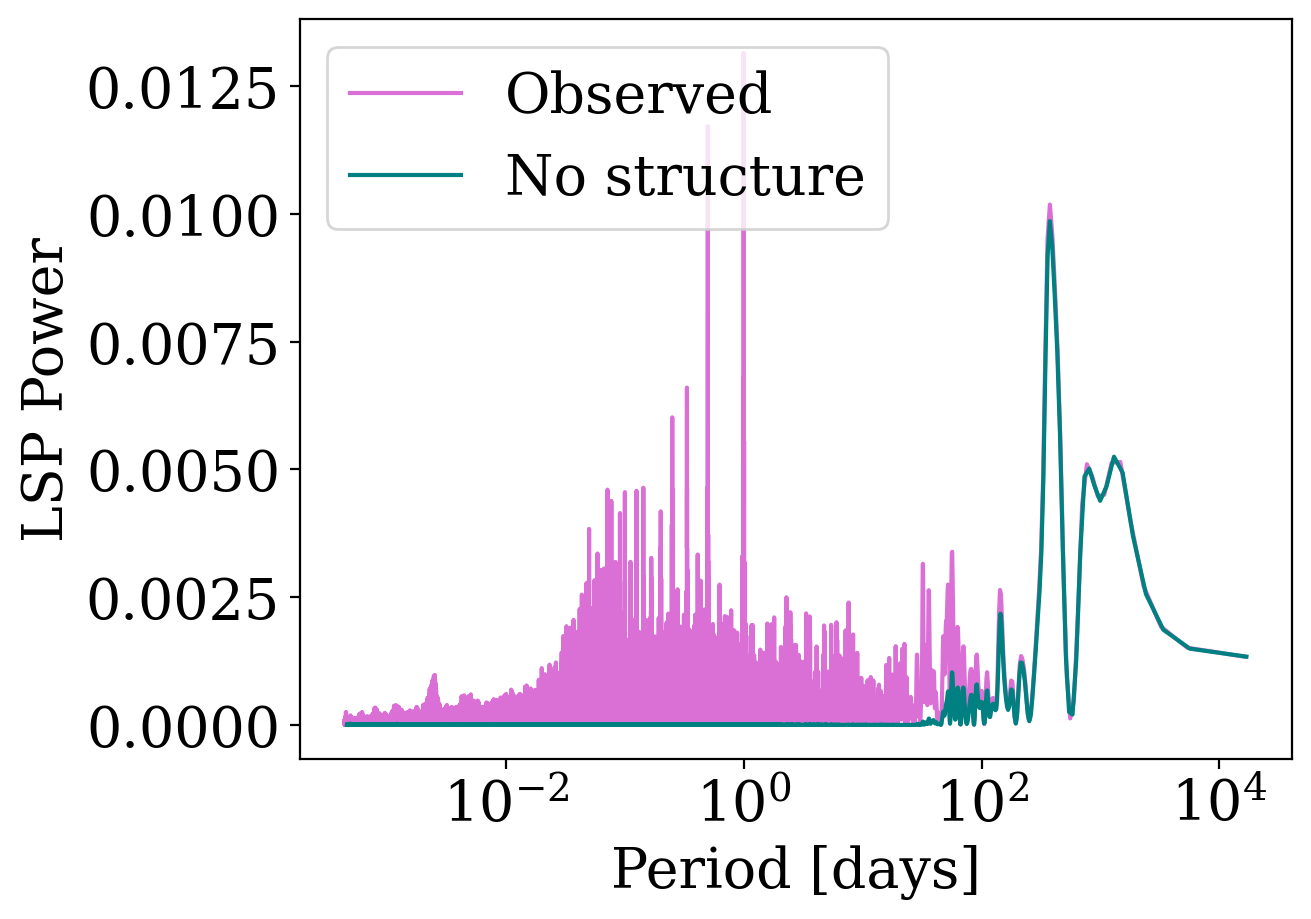

In [243]:
plt.plot(1/frequency, power, color='orchid', label='Observed')
plt.plot(1/frequency2, power2, color='teal', label='No structure')
plt.xscale('log')
plt.legend()
plt.xlabel("Period [days]")
plt.ylabel("LSP Power")

In [244]:
frequency[np.argmax(power)]

1.0026991120438322

In [375]:
N, bbx = np.histogram(xloc, 
             bins=np.arange(round(min(xloc))-1, 
                            round(max(xloc))+1,
                            step=0.041666667))

Text(0.5, 0, 'Dip Loc [MJD]')

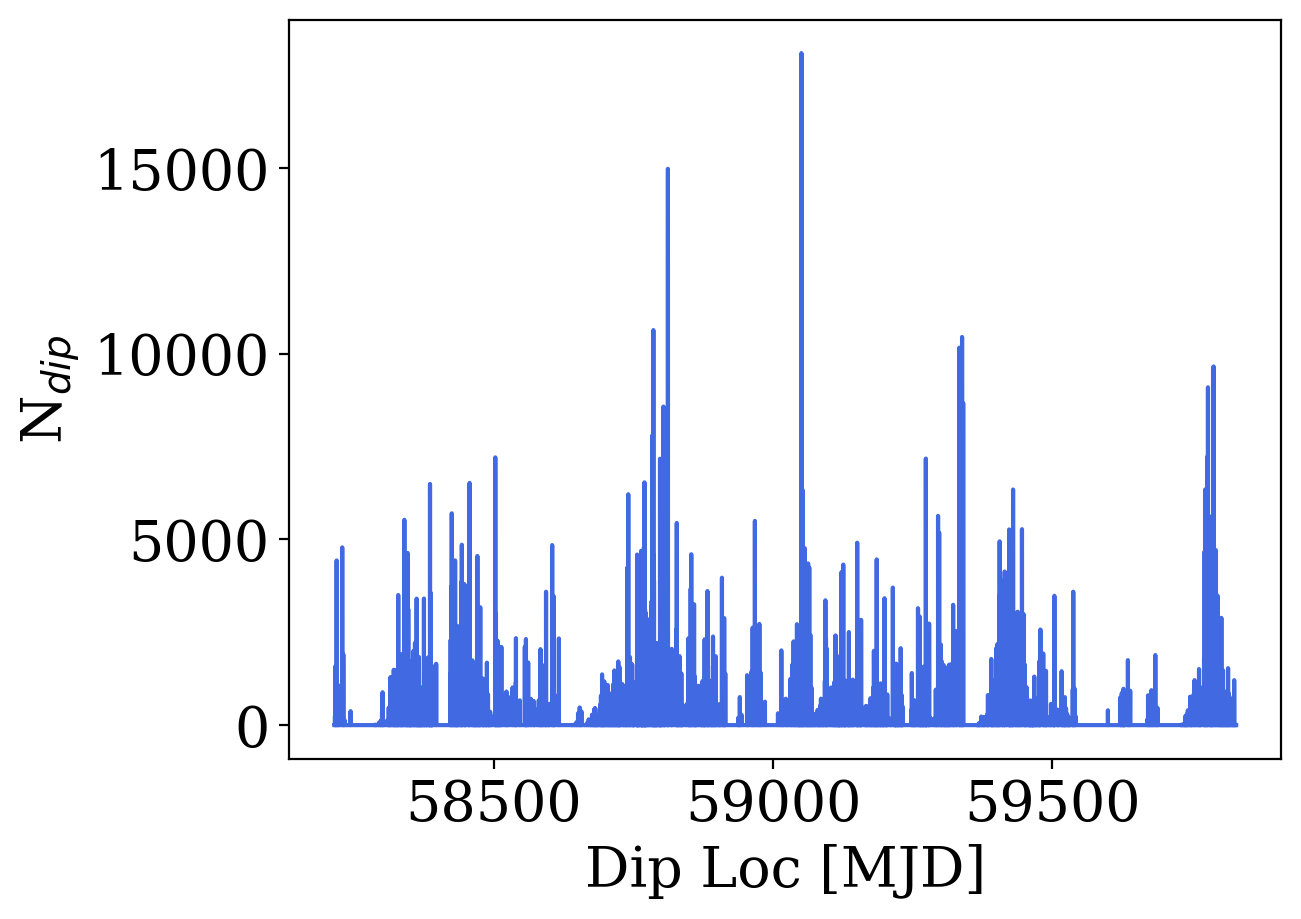

In [376]:
plt.plot(bbx[1::]-1, N, color='royalblue')

plt.ylabel("N$_{dip}$")
plt.xlabel("Dip Loc [MJD]")



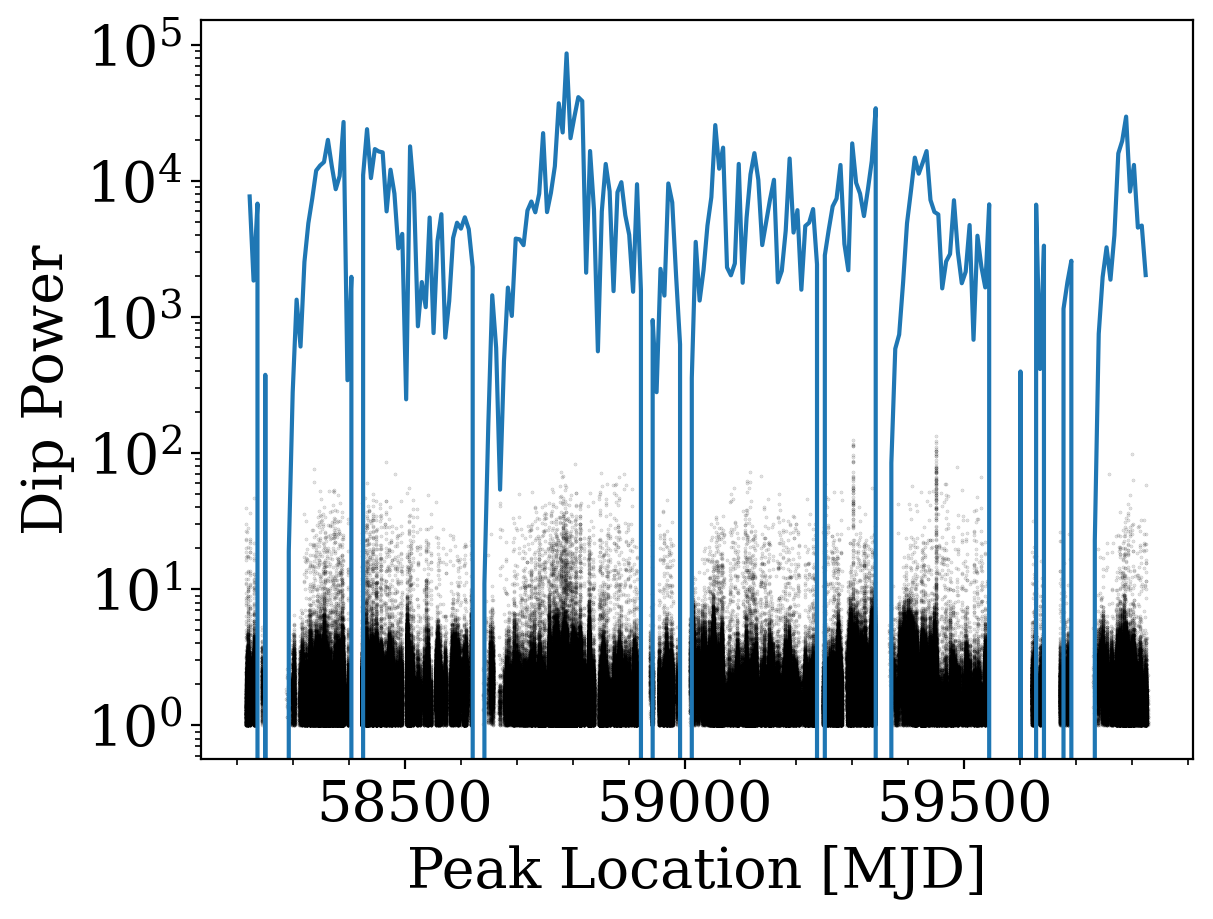

In [329]:
plt.plot(bbx[1::], N)
plt.scatter(xloc, ypow,
            s=0.1, 
            color='k',
            alpha=0.2)

plt.minorticks_on()
plt.ylabel("Dip Power")
plt.xlabel("Peak Location [MJD]")
plt.yscale('log')


In [447]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, s=0.01, color='k', alpha=0.1)
    ax.set_xlim(min(x)-50, max(x)+50)
    ax.set_yscale('log')
    ax.set_ylim(0)
    ax.set_xlabel("$\mu_{loc}$ [MJD]")
    ax.set_ylabel("Dip Deviation")
    ax.set_ylim(1, 50)
    
    # now determine nice limits by hand:
    binwidth = 10
    xymax = max(np.max(np.abs(x)), 20)
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=np.arange(min(x)-1, max(x)+1,
                                   step=5), color='k', histtype='stepfilled')
    
    ax_histx.spines['right'].set_visible(False)
    ax_histx.spines['left'].set_visible(False)
    ax_histx.spines['top'].set_visible(False)


    #ax_histx.yaxis.set_ticks_position('left')
    #ax_histx.xaxis.set_ticks_position('right')
    
    
    ax_histy.hist((y[y<10]), bins=2_000, orientation='horizontal', histtype='stepfilled',
                 color='k')
    ax_histy.set_yscale('log')

<>:11: DeprecationWarning: invalid escape sequence '\m'
<>:11: DeprecationWarning: invalid escape sequence '\m'
/tmp/ipykernel_96059/3691576906.py:11: DeprecationWarning: invalid escape sequence '\m'
  ax.set_xlabel("$\mu_{loc}$ [MJD]")


/tmp/ipykernel_96059/3691576906.py:10: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0)


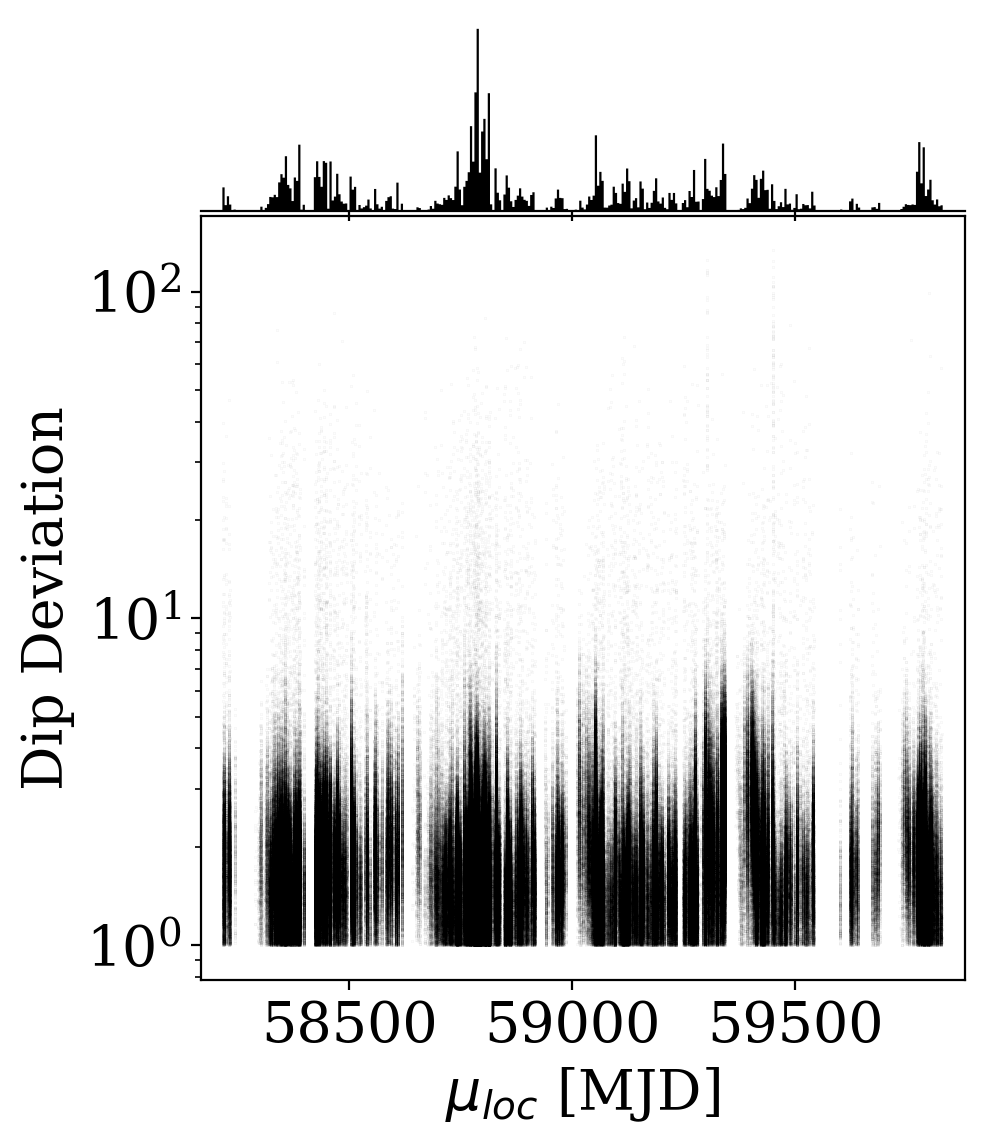

In [448]:
# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.01, hspace=0.01)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
#ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

ax_histy.set_yticks([])
ax_histx.set_yticks([])


# Draw the scatter plot and marginals.
scatter_hist(xloc, ypow, ax, ax_histx, ax_histy)
